# Algoritmo Genético - resolução do problema da mochila
Este trabalho foi desenvolvido como requisito parcial da disciplina de Inteligência Artificial, com o objetivo de aplicar conceitos de otimização utilizando Algoritmos Genéticos (AGs).

O Problema da Mochila (Knapsack Problem) é um problema clássico de otimização combinatória no qual se deseja selecionar, dentre um conjunto de itens disponíveis, aqueles que proporcionam o maior valor total, respeitando restrições de capacidade.

#### Trabalho feito por: Davi Henrique, Kaiki Alvarenga e Layla Melo

In [22]:
# comando para instalar as dependencias necessarias:
# pip install numpy pandas matplotlib seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [23]:
# Configuração de estilo para os gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [24]:


def gerar_produtos(qtd):
    produtos = []
    
    tipos = [
        "Açai", "Fundo", "ETF", "CDB", "Tesouro", "Cripto",  "Multimercado"
    ]
    
    setores = [
        "Tech", "Varejo", "Energia", "Financeiro", 
        "Imobiliário", "Internacional", "Industrial", "Serviços"
    ]
    
    for i in range(qtd):
        tipo = random.choice(tipos)
        setor = random.choice(setores)
        nome = f"{tipo} {setor} {i+1}"
        retorno = round(random.uniform(4, 20), 1)   # 4% a 20%
        risco    = round(random.uniform(1, 10), 1)   # 1 a 10
        custo    = random.randint(800, 6000)         # R$800 a R$6000
        produtos.append({
            "nome": nome,
            "retorno": retorno,
            "risco": risco,
            "custo": custo
        })
    return produtos


In [26]:
# Produtos de investimento disponíveis
produtos = gerar_produtos(10)
"""
Exmplo de dados Estaticos
    {"nome": "Ação Tech A", "retorno": 15.5, "risco": 8.2, "custo": 5000},
    {"nome": "Ação Tech B", "retorno": 12.3, "risco": 6.5, "custo": 4500},
    {"nome": "Fundo Imobiliário", "retorno": 9.8, "risco": 4.3, "custo": 3000},
    {"nome": "Tesouro Direto", "retorno": 6.5, "risco": 1.5, "custo": 1000},
    {"nome": "CDB Banco", "retorno": 7.2, "risco": 2.0, "custo": 2000},
    {"nome": "Ação Varejo", "retorno": 11.5, "risco": 7.0, "custo": 3500},
    {"nome": "ETF Internacional", "retorno": 13.2, "risco": 6.8, "custo": 4000},
    {"nome": "Fundo Multimercado", "retorno": 10.5, "risco": 5.5, "custo": 3200},
    {"nome": "Debênture", "retorno": 8.5, "risco": 3.8, "custo": 2500},
    {"nome": "Cripto Index", "retorno": 18.5, "risco": 9.5, "custo": 6000},
    {"nome": "Ação Energia", "retorno": 10.8, "risco": 4.9, "custo": 3800},
    {"nome": "Tesouro IPCA+", "retorno": 5.9, "risco": 1.0, "custo": 1500},
    {"nome": "Tesouro Selic", "retorno": 5.5, "risco": 1.0, "custo": 1000}
 """
MAX_PRODUTOS = 6       # Número máximo de produtos
RISCO_MAX = 35         # Risco máximo aceitável
# Parametro do Algoritmo
TAM_POPULACAO = 50   # Tamanho da população
NUM_GERACOES = 100      # Número de gerações
TAXA_CROSSOVER = 0.8    # Taxa de crossover (80%)
TAXA_MUTACAO = 0.05     # Taxa de mutação (5%)

In [27]:
"""
    Calcula o fitness de um cromossomo.
    Fitness = Retorno Total - Penalidades
    Penalidades:
    - Excesso de orçamento × 0.5
    - Excesso de risco × 2.0
    - Excesso de produtos × 10
    """
def calcular_fitness(cromossomo):
    retorno_total = 0
    risco_total = 0
    custo_total = 0
    num_produtos = 0
    # Calcula totais
    for i, gene in enumerate(cromossomo):
        if gene == 1:
            retorno_total += produtos[i]["retorno"]
            risco_total += produtos[i]["risco"]
            custo_total += produtos[i]["custo"]
            num_produtos += 1
    # Calcula penalidades
    penalidade = 0
    if custo_total > ORCAMENTO_MAX:
        penalidade += (custo_total - ORCAMENTO_MAX) * 0.5
    if risco_total > RISCO_MAX:
        penalidade += (risco_total - RISCO_MAX) * 2.0
    if num_produtos > MAX_PRODUTOS:
        penalidade += (num_produtos - MAX_PRODUTOS) * 10
    # Fitness final
    fitness = retorno_total - penalidade
    return max(0, fitness)  # Garante que fitness não seja negativo


In [28]:
"""
    Cria população inicial de forma aleatória.
    Probabilidade de 30% de cada gene ser 1 (selecionado).
"""
def criar_populacao_inicial(tamanho): 
    populacao = []
    for _ in range(tamanho):
        cromossomo = np.random.choice([0, 1], size=len(produtos), p=[0.7, 0.3])
        populacao.append(cromossomo)
    return populacao

In [29]:
"""
    Seleção por Torneio.
    Escolhe k indivíduos aleatórios e retorna o melhor.
"""
def selecao_torneio(populacao, fitness, k=3):
    indices = np.random.choice(len(populacao), k, replace=False)
    fitness_torneio = [fitness[i] for i in indices]
    melhor_idx = indices[np.argmax(fitness_torneio)]
    return populacao[melhor_idx].copy()
"""
    Crossover de 1 ponto.
    Com probabilidade 'taxa', gera dois filhos a partir de um ponto de corte.
"""
def crossover_um_ponto(pai1, pai2, taxa):
    if np.random.random() > taxa:
        return pai1.copy(), pai2.copy()
    ponto = np.random.randint(1, len(pai1))
    filho1 = np.concatenate([pai1[:ponto], pai2[ponto:]])
    filho2 = np.concatenate([pai2[:ponto], pai1[ponto:]])
    return filho1, filho2
"""
    Mutação por inversão de bit.
    Cada gene tem probabilidade 'taxa' de ser invertido (0->1 ou 1->0).
"""
def mutacao_bit_flip(cromossomo, taxa):
    cromossomo_mutado = cromossomo.copy()
    for i in range(len(cromossomo_mutado)):
        if np.random.random() < taxa:
            cromossomo_mutado[i] = 1 - cromossomo_mutado[i]
    return cromossomo_mutado

In [30]:
"""
    Executa o Algoritmo Genético completo.
    Retorna a população final e o histórico de evolução.
 """
def executar_ag(tam_pop=TAM_POPULACAO, num_ger=NUM_GERACOES, taxa_cross=TAXA_CROSSOVER, taxa_mut=TAXA_MUTACAO, verbose=True):
    # Cria população inicial
    populacao = criar_populacao_inicial(tam_pop)
    # Histórico para análise
    historico = {
        'geracao': [],
        'melhor_fitness': [],
        'fitness_medio': [],
        'fitness_pior': []
    }
    # Loop principal
    for geracao in range(num_ger):
        # Calcula fitness de todos os indivíduos
        fitness = [calcular_fitness(cromossomo) for cromossomo in populacao]
        # Guarda estatísticas
        historico['geracao'].append(geracao)
        historico['melhor_fitness'].append(max(fitness))
        historico['fitness_medio'].append(np.mean(fitness))
        historico['fitness_pior'].append(min(fitness))
        # Mostra progresso
        if verbose and (geracao % 20 == 0 or geracao == num_ger - 1):
            print(f"Geração {geracao:3d} | Melhor: {max(fitness):6.2f} | Médio: {np.mean(fitness):6.2f}")
        # Nova população (com elitismo)
        melhor_idx = np.argmax(fitness)
        nova_populacao = [populacao[melhor_idx].copy()]  # Elitismo
        # Gera novos indivíduos
        while len(nova_populacao) < tam_pop:
            # Seleção
            pai1 = selecao_torneio(populacao, fitness)
            pai2 = selecao_torneio(populacao, fitness)
            # Crossover
            filho1, filho2 = crossover_um_ponto(pai1, pai2, taxa_cross)
            # Mutação
            filho1 = mutacao_bit_flip(filho1, taxa_mut)
            filho2 = mutacao_bit_flip(filho2, taxa_mut)
            # Adiciona à nova população
            nova_populacao.append(filho1)
            if len(nova_populacao) < tam_pop:
                nova_populacao.append(filho2)
        populacao = nova_populacao
    return populacao, historico
print("="*70)
print("EXECUTANDO ALGORITMO GENÉTICO - SELEÇÃO DE PORTFÓLIO")
print("="*70)
print(f"\nParâmetros:")
print(f"  - População: {TAM_POPULACAO}")
print(f"  - Gerações: {NUM_GERACOES}")
print(f"  - Taxa Crossover: {TAXA_CROSSOVER*100}%")
print(f"  - Taxa Mutação: {TAXA_MUTACAO*100}%")
print(f"\nRestrições:")
print(f"  - Orçamento Máximo: R$ {ORCAMENTO_MAX:,.2f}")
print(f"  - Risco Máximo: {RISCO_MAX}")
print(f"  - Máximo de Produtos: {MAX_PRODUTOS}")
print("\n" + "="*70)

# Executa AG
populacao_final, historico = executar_ag()

EXECUTANDO ALGORITMO GENÉTICO - SELEÇÃO DE PORTFÓLIO

Parâmetros:
  - População: 50
  - Gerações: 100
  - Taxa Crossover: 80.0%
  - Taxa Mutação: 5.0%

Restrições:
  - Orçamento Máximo: R$ 15,000.00
  - Risco Máximo: 35
  - Máximo de Produtos: 6

Geração   0 | Melhor:  66.70 | Médio:  32.80
Geração  20 | Melhor:  86.70 | Médio:  69.13
Geração  40 | Melhor:  86.70 | Médio:  72.21
Geração  60 | Melhor:  86.70 | Médio:  68.85
Geração  80 | Melhor:  86.70 | Médio:  64.65
Geração  99 | Melhor:  86.70 | Médio:  63.21


In [31]:
# Encontra melhor solução
fitness_final = [calcular_fitness(c) for c in populacao_final]
melhor_idx = np.argmax(fitness_final)
melhor_cromossomo = populacao_final[melhor_idx]

# Calcula características da melhor solução
produtos_selecionados = []
retorno_total = 0
risco_total = 0
custo_total = 0

for i, gene in enumerate(melhor_cromossomo):
    if gene == 1:
        produtos_selecionados.append(produtos[i])
        retorno_total += produtos[i]["retorno"]
        risco_total += produtos[i]["risco"]
        custo_total += produtos[i]["custo"]

print("\n" + "="*70)
print("MELHOR SOLUÇÃO ENCONTRADA")
print("="*70)
print(f"\nFitness: {fitness_final[melhor_idx]:.2f}")
print(f"Retorno Total: {retorno_total:.2f}%")
print(f"Risco Total: {risco_total:.2f}")
print(f"Custo Total: R$ {custo_total:,.2f}")
print(f"Número de Produtos: {len(produtos_selecionados)}")

print("\n" + "-"*70)
print("PRODUTOS SELECIONADOS:")
print("-"*70)
for p in produtos_selecionados:
    print(f"  • {p['nome']:20s} | Retorno: {p['retorno']:5.1f}% | Risco: {p['risco']:4.1f} | Custo: R$ {p['custo']:,}")


MELHOR SOLUÇÃO ENCONTRADA

Fitness: 86.70
Retorno Total: 86.70%
Risco Total: 26.20
Custo Total: R$ 14,574.00
Número de Produtos: 6

----------------------------------------------------------------------
PRODUTOS SELECIONADOS:
----------------------------------------------------------------------
  • Açai Imobiliário 2   | Retorno:  16.3% | Risco:  2.7 | Custo: R$ 2,343
  • CDB Energia 3        | Retorno:  19.1% | Risco:  1.1 | Custo: R$ 5,577
  • CDB Serviços 4       | Retorno:  17.1% | Risco:  7.9 | Custo: R$ 3,238
  • ETF Serviços 6       | Retorno:  19.5% | Risco:  5.9 | Custo: R$ 1,068
  • Açai Industrial 8    | Retorno:  10.4% | Risco:  2.5 | Custo: R$ 956
  • Cripto Varejo 10     | Retorno:   4.3% | Risco:  6.1 | Custo: R$ 1,392


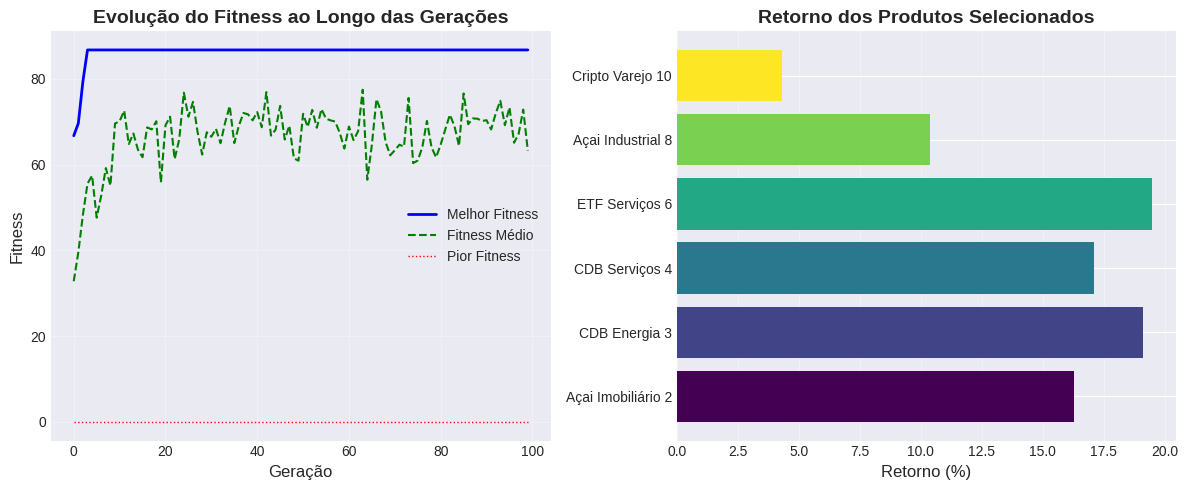

In [32]:
# Converte histórico para DataFrame
df_hist = pd.DataFrame(historico)

# Gráfico 1: Evolução do Fitness
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df_hist['geracao'], df_hist['melhor_fitness'], 'b-', linewidth=2, label='Melhor Fitness')
plt.plot(df_hist['geracao'], df_hist['fitness_medio'], 'g--', linewidth=1.5, label='Fitness Médio')
plt.plot(df_hist['geracao'], df_hist['fitness_pior'], 'r:', linewidth=1, label='Pior Fitness')
plt.xlabel('Geração', fontsize=12)
plt.ylabel('Fitness', fontsize=12)
plt.title('Evolução do Fitness ao Longo das Gerações', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
# Gráfico 2: Produtos Selecionados
plt.subplot(1, 2, 2)
nomes = [p['nome'] for p in produtos_selecionados]
retornos = [p['retorno'] for p in produtos_selecionados]
cores = plt.cm.viridis(np.linspace(0, 1, len(nomes)))
bars = plt.barh(nomes, retornos, color=cores)
plt.xlabel('Retorno (%)', fontsize=12)
plt.title('Retorno dos Produtos Selecionados', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


EXPERIMENTO COMPARATIVO: TAXA DE MUTAÇÃO

Testando taxa de mutação: 2.0%
  → Melhor Fitness: 51.20

Testando taxa de mutação: 5.0%
  → Melhor Fitness: 52.20

Testando taxa de mutação: 10.0%
  → Melhor Fitness: 52.20

Testando taxa de mutação: 20.0%
  → Melhor Fitness: 52.20


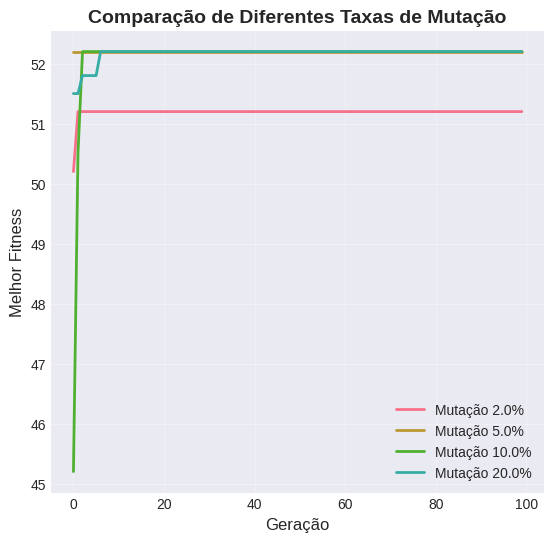

In [6]:
print("\n" + "="*70)
print("EXPERIMENTO COMPARATIVO: TAXA DE MUTAÇÃO")
print("="*70)

taxas_mutacao = [0.02, 0.05, 0.10, 0.20]
resultados_comparacao = []

for taxa in taxas_mutacao:
    print(f"\nTestando taxa de mutação: {taxa*100}%")
    pop_final, hist = executar_ag(taxa_mut=taxa, verbose=False)
    
    # Melhor fitness final
    fitness_f = [calcular_fitness(c) for c in pop_final]
    melhor_fitness = max(fitness_f)
    
    resultados_comparacao.append({
        'taxa': taxa,
        'melhor_fitness': melhor_fitness,
        'historico': hist
    })
    
    print(f"  → Melhor Fitness: {melhor_fitness:.2f}")

# Gráfico Comparativo
plt.figure(figsize=(14, 6))

# Evolução comparativa
plt.subplot(1, 2, 1)
for resultado in resultados_comparacao:
    df_temp = pd.DataFrame(resultado['historico'])
    plt.plot(df_temp['geracao'], df_temp['melhor_fitness'], 
             linewidth=2, label=f"Mutação {resultado['taxa']*100}%")

plt.xlabel('Geração', fontsize=12)
plt.ylabel('Melhor Fitness', fontsize=12)
plt.title('Comparação de Diferentes Taxas de Mutação', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)